In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, List, Tuple, Dict


class PF:
    """
    Particle Filter.

    This filter uses a set of weighted particles to represent the posterior
    distribution, propagating them through nonlinear dynamics and updating
    weights based on measurements.

    Equations:
      Prediction:
        x_i^- = f(x_i^{k-1}) + w_i, where w_i ~ N(0, Q)

      Weight update:
        w_i = w_i * p(z_k | x_i^-)
        w_i = w_i / sum(w)

      Resampling (if N_eff < threshold):
        Draw N particles from {x_i} with probabilities {w_i}
        Set all weights to 1/N

      State estimate:
        x_mean = sum(w_i * x_i)
        P = sum(w_i * (x_i - x_mean)(x_i - x_mean)^T)
    """

    def __init__(
        self,
        f: Callable[[np.ndarray], np.ndarray],
        h: Callable[[np.ndarray], np.ndarray],
        Q: np.ndarray,
        R: np.ndarray,
        x0: np.ndarray,
        P0: np.ndarray,
        n_particles: int = 1000,
        resample_threshold: float = 0.5,
        state_constraints: Optional[Callable[[np.ndarray], np.ndarray]] = None,
        zero_cross_covariance: bool = True,
        p0_inflation_factor: float = 2.0,
        resample_jitter_scale: float = 0.05,
        max_cumulative_jitter: float = 6.0,
        adaptive_noise_scale: float = 2.0,
        min_eff_sample_ratio: float = 0.1,
    ):
        """
        Initialize PF.

        f: state transition function x_{k+1} = f(x_k) - must accept (N, n) array
        h: measurement function z_k = h(x_k) - must accept (N, n) array
        Q: process noise covariance
        R: measurement noise covariance
        x0: initial state mean
        P0: initial state covariance
        n_particles: number of particles
        resample_threshold: threshold for effective sample size (fraction of N)
        state_constraints: optional state constraints function - must accept (N, n) array
        zero_cross_covariance: optional zero-ing of cross-covariances
        p0_inflation_factor: factor to inflate initial covariance for particle spread
        resample_jitter_scale: scale factor for resampling diversity noise
        max_cumulative_jitter: maximum cumulative jitter for resampling diversity noise
        adaptive_noise_scale: scale factor for adaptive process noise inflation
        min_eff_sample_ratio: minimum effective sample size ratio for noise inflation
        """
        # Check dimensions of Q and P0 match state dimension
        assert Q.shape == (len(x0), len(x0)), "Q dimension mismatch"
        assert P0.shape == (len(x0), len(x0)), "P0 dimension mismatch"

        self.f = f
        self.h = h
        self.Q = Q.copy()
        self.R = R.copy()
        self.state_constraints = state_constraints
        self.zero_cross_covariance = zero_cross_covariance

        # Initialize state and covariance
        self.x = x0.copy()
        self.P = P0.copy()

        # Particle filter specific parameters
        self.n = len(x0)
        self.n_particles = n_particles
        self.resample_threshold = resample_threshold
        self.p0_inflation_factor = p0_inflation_factor
        self.resample_jitter_scale = resample_jitter_scale
        self.cumulative_jitter: np.ndarray = np.zeros(self.n)
        self.max_cumulative_jitter = max_cumulative_jitter
        self.adaptive_noise_scale = adaptive_noise_scale
        self.min_eff_sample_ratio = min_eff_sample_ratio

        # Initialize particles with inflated covariance for better coverage
        P0_inflated = P0 * self.p0_inflation_factor
        self.particles = np.random.multivariate_normal(
            x0, P0_inflated, size=n_particles
        )

        # Apply constraints to initial particles if needed
        if self.state_constraints:
            self.particles = self.state_constraints(self.particles)

        # Initialize uniform weights
        self.weights = np.ones(n_particles) / n_particles

        # Precompute constants for likelihood computation
        self.log_2pi = np.log(2 * np.pi)

        # Initialize histories for diagnostics
        self.state_history: List[np.ndarray] = [self.x.copy()]
        self.cov_history: List[np.ndarray] = [self.P.copy()]
        self.innovations: List[np.ndarray] = []
        self.innovation_covariances: List[np.ndarray] = []
        self._innovations_filt: List[np.ndarray] = []
        self._innov_cov_filt: List[np.ndarray] = []
        self.eff_sample_size_history: List[float] = []
        self.particle_diversity_history: List[np.ndarray] = []

    def _compute_effective_sample_size(self) -> float:
        """
        Compute effective sample size N_eff = 1 / sum(w_i^2).

        This measures how well the particle set represents the posterior.
        """
        return 1.0 / np.sum(self.weights ** 2)

    def _compute_particle_diversity(self) -> np.ndarray:
        """
        Compute standard deviation of particles in each dimension.
        """
        return np.std(self.particles, axis=0)

    def _systematic_resample(self) -> None:
        """
        Perform systematic resampling of particles with adaptive diversity preservation.
        Uses log-space computations where beneficial for numerical stability.
        """
        N = self.n_particles

        # Ensure weights are normalized
        self.weights = self.weights / np.sum(self.weights)

        # Systematic resampling
        positions = (np.arange(N) + np.random.uniform()) / N

        cumsum = np.cumsum(self.weights)
        indices = np.searchsorted(cumsum, positions)

        # Resample particles
        self.particles = self.particles[indices].copy()

        # Add adaptive noise based on particle spread for diversity
        particle_std = self._compute_particle_diversity()

        # Noise scales
        noise_scales = self.resample_jitter_scale * particle_std

        # Check cumulative jitter and cap if needed:
        # Compute per-dimension caps
        max_allowed = self.max_cumulative_jitter * particle_std  # shape (n,)

        # Build a boolean mask of "over-jittered" dims
        over = self.cumulative_jitter > max_allowed  # shape (n,)

        # Dampen only those dims in one shot
        noise_scales[over] *= 0.1

        # Vectorized noise addition
        noise = np.random.normal(0, 1, (N, self.n)) * noise_scales[np.newaxis, :]
        self.particles += noise

        # Track cumulative jitter
        self.cumulative_jitter += np.mean(np.abs(noise), axis=0)

        # Apply constraints after adding noise
        if self.state_constraints:
            self.particles = self.state_constraints(self.particles)

        # Reset weights to uniform and ensure exact normalization
        self.weights = np.ones(N) / float(N)

    def _compute_log_likelihoods_vectorized(
        self,
        innovations: np.ndarray,
        R: np.ndarray
    ) -> np.ndarray:
        """
        Compute log-likelihood log(p(z | x)) for all particles at once.

        innovations: (N, m) array of measurement innovations
        R: (m, m) measurement noise covariance
        Returns: (N,) array of log-likelihoods
        """
        m = innovations.shape[1]

        try:
            # Cholesky decomposition with regularization for stability
            R_reg = R + 1e-9 * np.eye(m)
            L = np.linalg.cholesky(R_reg)

            # Solve L * Y = innovations^T for all particles at once
            # Y has shape (m, N)
            Y = np.linalg.solve(L, innovations.T)

            # Compute squared Mahalanobis distance for all particles
            # Sum over measurement dimensions (axis=0)
            mahalanobis_sq = np.sum(Y * Y, axis=0)

            # Compute log determinant
            log_det_R = 2 * np.sum(np.log(np.diag(L)))

            # Compute log likelihoods
            log_likelihoods = -0.5 * (mahalanobis_sq + m * self.log_2pi + log_det_R)

            return log_likelihoods

        except np.linalg.LinAlgError:
            # Try with larger regularization
            try:
                R_reg = R + 1e-6 * np.eye(m)
                L = np.linalg.cholesky(R_reg)
                # Repeat computation with more regularization
                Y = np.linalg.solve(L, innovations.T)
                mahalanobis_sq = np.sum(Y * Y, axis=0)
                log_det_R = 2 * np.sum(np.log(np.diag(L)))
                log_likelihoods = -0.5 * (mahalanobis_sq + m * self.log_2pi + log_det_R)
                return log_likelihoods
            except:
                # Fallback: return very small but measurement-dimension-aware value
                return np.full(len(innovations), -100.0 * m)

    def _estimate_mean_and_covariance(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Estimate mean and covariance from weighted particles.

        x_mean = sum(w_i * x_i)
        P = sum(w_i * (x_i - x_mean)(x_i - x_mean)^T)
        """
        # Verify weight normalization
        weight_sum = np.sum(self.weights)
        assert np.abs(weight_sum - 1.0) < 1e-10, f"Weights not normalized: sum = {weight_sum}"

        # Compute weighted mean using einsum for efficiency
        x_mean = np.einsum('i,ij->j', self.weights, self.particles)

        # Compute weighted covariance
        deviations = self.particles - x_mean[np.newaxis, :]

        # Use einsum for efficient weighted outer product sum
        P = np.einsum('i,ij,ik->jk', self.weights, deviations, deviations)

        # Ensure symmetry
        P = 0.5 * (P + P.T)

        return x_mean, P

    def _sample_process_noise(self, noise_scale: float) -> np.ndarray:
        """
        Sample process noise with numerical stability checks.
        """
        # Add small regularization to Q for numerical stability
        Q_scaled = self.Q * noise_scale
        Q_reg = Q_scaled + 1e-12 * np.eye(self.n)

        try:
            # Use Cholesky decomposition for efficient sampling
            L = np.linalg.cholesky(Q_reg)
            # Generate standard normal samples and transform
            z = np.random.standard_normal((self.n_particles, self.n))
            return z @ L.T
        except np.linalg.LinAlgError:
            # Fallback to eigendecomposition if Cholesky fails
            eigvals, eigvecs = np.linalg.eigh(Q_reg)
            eigvals = np.maximum(eigvals, 1e-12)
            L = eigvecs @ np.diag(np.sqrt(eigvals))
            z = np.random.standard_normal((self.n_particles, self.n))
            return z @ L.T

    def predict(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Perform prediction step of PF.

        Steps:
          1. Propagate all particles through f (vectorized).
          2. Add process noise (with adaptive inflation if needed).
          3. Apply constraints to final state.
          4. Update mean and covariance estimates.
        """
        # Check if we need adaptive noise inflation based on previous effective sample size
        noise_scale = 1.0
        if len(self.eff_sample_size_history) > 0:
            last_eff_ratio = self.eff_sample_size_history[-1] / self.n_particles
            if last_eff_ratio < self.min_eff_sample_ratio:
                # Inflate noise to prevent particle collapse
                noise_scale = self.adaptive_noise_scale

        # Vectorized state transition for all particles
        new_particles = self.f(self.particles)

        # Add process noise with numerical stability
        process_noise = self._sample_process_noise(noise_scale)
        new_particles += process_noise

        # Apply constraints to final state (vectorized)
        if self.state_constraints:
            new_particles = self.state_constraints(new_particles)

        self.particles = new_particles

        # Update state estimate
        self.x, self.P = self._estimate_mean_and_covariance()

        # Track particle diversity
        self.particle_diversity_history.append(self._compute_particle_diversity())

        return self.x.copy(), self.P.copy()

    def update(self, z: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Perform measurement update of PF.

        Steps:
        1. Compute predicted measurement for all particles (vectorized).
        2. Store predicted innovation statistics.
        3. Update particle weights based on measurement likelihood (in log space).
        4. Normalize weights.
        5. Resample if effective sample size is too low.
        6. Update mean and covariance estimates.
        7. Compute filtered innovation statistics.
        """
        # Store predicted estimates for innovation computation
        x_pred = self.x.copy()
        P_pred = self.P.copy()

        # Update measurement dimension
        m = len(z)

        # Vectorized measurement prediction for all particles
        z_particles = self.h(self.particles)

        # Store pre-update weights and particles for predicted innovation covariance
        weights_pred = self.weights.copy()

        # Compute predicted innovation statistics BEFORE weight update
        z_pred_mean = np.einsum('i,ij->j', weights_pred, z_particles)

        # Store predicted innovation (use Monte Carlo mean for consistency)
        innov_pred = z - z_pred_mean

        # Compute predicted innovation covariance
        z_deviations_pred = z_particles - z_pred_mean[np.newaxis, :]
        Pzz_pred = np.einsum('i,ij,ik->jk', weights_pred, z_deviations_pred, z_deviations_pred)
        Pzz_pred += self.R

        self.innovations.append(innov_pred)
        self.innovation_covariances.append(Pzz_pred)

        # Compute innovations for all particles
        innovations = z[np.newaxis, :] - z_particles  # Shape: (n_particles, m)

        # Compute log-likelihoods for numerical stability
        log_likelihoods = self._compute_log_likelihoods_vectorized(innovations, self.R)

        # Update weights in log space to prevent underflow:
        # Convert current weights to log space
        log_weights = np.log(self.weights + 1e-300)

        # Add log-likelihoods
        log_weights += log_likelihoods

        # Normalize in log space by subtracting the maximum
        log_weights_max = np.max(log_weights)
        log_weights -= log_weights_max

        # Convert back to standard space
        self.weights = np.exp(log_weights)

        # Normalize weights
        weight_sum = np.sum(self.weights)
        if weight_sum > 1e-300:
            self.weights /= weight_sum
        else:
            # Reset to uniform if all weights are effectively zero
            self.weights = np.ones(self.n_particles) / self.n_particles

        # Compute effective sample size
        n_eff = self._compute_effective_sample_size()
        self.eff_sample_size_history.append(n_eff)

        # Resample if effective sample size is too low
        if n_eff < self.resample_threshold * self.n_particles:
            self._systematic_resample()
            # Recompute measurements after resampling for filtered statistics
            z_particles = self.h(self.particles)

        # Update state estimate
        self.x, self.P = self._estimate_mean_and_covariance()

        # Apply final constraints to mean estimate
        if self.state_constraints:
            x_old = self.x.copy()
            self.x = self.state_constraints(self.x.reshape(1, -1)).ravel()

            # If mean was clipped, also ensure all particles respect constraints
            if not np.allclose(self.x, x_old):
                self.particles = self.state_constraints(self.particles)
                # Re-estimate covariance after constraining particles
                _, self.P = self._estimate_mean_and_covariance()

            # Inflate covariance for clipped dimensions:
            # Build boolean mask of clipped dims
            clipped = (self.x != x_old)  # shape (n,)

            # Compute per-dimension inflation
            diff = x_old - self.x  # shape (n,)
            inflation = diff**2    # shape (n,)

            # Add inflation to the diagonal only where clipped==True
            idx = np.arange(self.n)
            self.P[idx, idx] += inflation * clipped

            if self.zero_cross_covariance:
                # Temporarily save the new diagonal values for clipped dims
                new_diag = self.P[idx, idx].copy()

                # Zero-out full rows and columns for those dims
                self.P[clipped, :] = 0.0
                self.P[:, clipped] = 0.0

                # Restore the inflated diagonal entries
                self.P[idx[clipped], idx[clipped]] = new_diag[clipped]

        # Ensure positive definiteness
        self.P = 0.5 * (self.P + self.P.T)
        eigs = np.linalg.eigvalsh(self.P)
        if np.min(eigs) < 1e-9:
            self.P += (1e-9 - np.min(eigs)) * np.eye(self.n)

        # Compute filtered innovation statistics
        z_f = self.h(self.x.reshape(1, -1)).ravel()
        self._innovations_filt.append(z - z_f)

        # Compute filtered innovation covariance using current weights and particles
        z_mean_filt = np.einsum('i,ij->j', self.weights, z_particles)
        z_deviations_filt = z_particles - z_mean_filt[np.newaxis, :]
        Pzz_f = np.einsum('i,ij,ik->jk', self.weights, z_deviations_filt, z_deviations_filt)
        Pzz_f += self.R
        self._innov_cov_filt.append(Pzz_f)

        # Store histories
        self.state_history.append(self.x.copy())
        self.cov_history.append(self.P.copy())

        return self.x.copy(), self.P.copy()

    def run_sequence(
        self,
        measurements: np.ndarray,
        steps_per_meas: int
    ) -> np.ndarray:
        """
        Run PF over a sequence of measurements.

        For each measurement z_k:
          - Call predict() steps_per_meas times
          - Call update(z_k)
        Returns array of state_history excluding initial state.
        """
        for z in measurements:
            for _ in range(steps_per_meas):
                self.predict()
            self.update(z)
        return np.array(self.state_history)[1:]

    def get_nis(self, method: str = 'predicted') -> Optional[float]:
        """
        Compute average Normalized Innovation Squared (NIS).

        method: 'predicted' uses pre-update innovations,
                'filtered' uses post-update innovations.
        """
        if method == 'predicted':
            inn_list = self.innovations
            S_list = self.innovation_covariances
        elif method == 'filtered':
            inn_list = self._innovations_filt
            S_list = self._innov_cov_filt
        else:
            raise ValueError("method must be 'predicted' or 'filtered'")

        if not inn_list:
            return None

        nis_vals = []
        for inn, S in zip(inn_list, S_list):
            try:
                # NIS = innov^T S^{-1} innov
                S_reg = S + 1e-6 * np.eye(len(inn))
                nis = float(inn.T @ np.linalg.inv(S_reg) @ inn)
                nis_vals.append(nis)
            except np.linalg.LinAlgError:
                continue

        return float(np.mean(nis_vals)) if nis_vals else None

In [2]:
class GolfBallPhysics:
    """
    Golf ball physics: quadratic drag plus Magnus effect plus spin decay.

    Fully vectorized to handle multiple particles at once.

    State x = [pos(3), vel(3), spin(3)]
    Equations:
      Fd = -0.5 * rho * Cd * A * |v| * v
      Fm =  0.5 * rho * Cl * A * cross(spin, v)
      a = (Fd + Fm) / m - [0,0,g]

    Integration using RK4 for better accuracy.
    """

    def __init__(self, dt: float = 0.01):
        """
        Initialize physics parameters.
        dt: time step size
        """
        self.dt = dt
        self.m = 0.04593
        self.r = 0.02135
        self.A = np.pi * self.r**2
        self.g = 9.81
        self.rho = 1.225
        self.Cd = 0.25
        self.Cl = 0.2

    def _compute_derivatives_vectorized(self, x: np.ndarray) -> np.ndarray:
        """
        Compute state derivatives dx/dt for multiple states.

        x: (N, 9) array of states
        Returns: (N, 9) array of derivatives
        """
        # Extract components
        pos = x[:, 0:3]
        vel = x[:, 3:6]
        spin = x[:, 6:9]

        # Compute drag vectorized: Fd = -0.5*rho*Cd*A*|v|*v
        v_mag = np.linalg.norm(vel, axis=1, keepdims=True)
        v_mag = np.maximum(v_mag, 1e-10)  # Avoid division by zero
        Fd = -0.5 * self.rho * self.Cd * self.A * v_mag * vel

        # Compute Magnus vectorized: Fm = 0.5*rho*Cl*A*cross(spin, vel)
        Fm = 0.5 * self.rho * self.Cl * self.A * np.cross(spin, vel)

        # Compute acceleration and apply gravity
        a = (Fd + Fm) / self.m
        a[:, 2] -= self.g

        # Spin decay
        spin_decay = -0.001 * spin

        # Stack derivatives [vel, accel, spin_decay]
        return np.hstack([vel, a, spin_decay])

    def state_transition(self, x: np.ndarray) -> np.ndarray:
        """
        Compute next state using RK4 integration.

        x: Either (9,) for single state or (N, 9) for multiple states
        Returns: Same shape as input
        """
        # Handle both single state and batch
        single_state = x.ndim == 1
        if single_state:
            x = x.reshape(1, -1)

        # RK4 integration (vectorized)
        k1 = self._compute_derivatives_vectorized(x)
        k2 = self._compute_derivatives_vectorized(x + 0.5 * self.dt * k1)
        k3 = self._compute_derivatives_vectorized(x + 0.5 * self.dt * k2)
        k4 = self._compute_derivatives_vectorized(x + self.dt * k3)

        # Combine slopes
        x_new = x + (self.dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

        return x_new.ravel() if single_state else x_new

In [3]:
class GolfSensorSystem:
    """
    Sensor system fusing radar and two cameras.

    Fully vectorized to handle multiple states at once.

    Radar: [range, radial velocity]
    Camera: [azimuth, elevation] angles.
    """

    def __init__(
        self,
        radar_pos: Optional[np.ndarray] = None,
        camera_positions: Optional[List[np.ndarray]] = None,
    ):
        """
        Initialize sensor positions and noise std deviations.
        """
        # Set radar position
        self.radar_pos = (
            radar_pos
            if radar_pos is not None
            else np.array([0.0, -5.0, 2.0])
        )
        # Set camera positions
        self.camera_positions = (
            camera_positions
            if camera_positions is not None
            else [
                np.array([-10.0, -5.0, 5.0]),
                np.array([10.0, -5.0, 5.0]),
            ]
        )
        self.radar_range_std = 0.5
        self.radar_velocity_std = 0.5
        self.camera_angle_std = 0.01

    def radar_measurement_vectorized(
        self,
        x: np.ndarray,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Compute radar measurement [range, radial velocity] for multiple states.

        x: (N, 9) array of states
        Returns: (N, 2) array of measurements
        """
        pos = x[:, 0:3]
        vel = x[:, 3:6]

        # Vectorized computation
        r_vec = pos - self.radar_pos[np.newaxis, :]
        r_mag = np.linalg.norm(r_vec, axis=1)
        r_mag = np.maximum(r_mag, 1e-10)
        r_hat = r_vec / r_mag[:, np.newaxis]

        # Radial velocity (dot product for each particle)
        v_rad = np.einsum('ij,ij->i', vel, r_hat)

        meas = np.column_stack([r_mag, v_rad])

        if add_noise:
            noise = np.random.normal(
                0,
                [self.radar_range_std, self.radar_velocity_std],
                meas.shape
            )
            meas += noise

        return meas

    def camera_measurement_vectorized(
        self,
        x: np.ndarray,
        camera_idx: int = 0,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Compute camera measurement [azimuth, elevation] for multiple states.

        x: (N, 9) array of states
        Returns: (N, 2) array of measurements
        """
        pos = x[:, 0:3]
        cam = self.camera_positions[camera_idx]
        r = pos - cam[np.newaxis, :]

        # Vectorized angle computation
        r_xy = np.sqrt(r[:, 0]**2 + r[:, 1]**2)
        r_xy = np.maximum(r_xy, 1e-10)

        az = np.arctan2(r[:, 1], r[:, 0])
        el = np.arctan2(r[:, 2], r_xy)

        meas = np.column_stack([az, el])

        if add_noise:
            noise = np.random.normal(0, self.camera_angle_std, meas.shape)
            meas += noise

        return meas

    def fused_measurement_vectorized(
        self,
        x: np.ndarray,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Fuse radar and two camera measurements into 6D vector for multiple states.

        x: (N, 9) array of states
        Returns: (N, 6) array of measurements
        """
        radar = self.radar_measurement_vectorized(x, add_noise)
        cam1 = self.camera_measurement_vectorized(x, 0, add_noise)
        cam2 = self.camera_measurement_vectorized(x, 1, add_noise)

        return np.hstack([radar, cam1, cam2])

    def measurement_function(self, x: np.ndarray) -> np.ndarray:
        """
        Measurement function (without noise) for PF update.

        x: Either (9,) for single state or (N, 9) for multiple states
        Returns: (6,) for single state or (N, 6) for multiple states
        """
        single_state = x.ndim == 1
        if single_state:
            x = x.reshape(1, -1)

        result = self.fused_measurement_vectorized(x, add_noise=False)

        return result.ravel() if single_state else result

In [4]:
def golf_ball_constraints_vectorized(x: np.ndarray) -> np.ndarray:
    """
    Enforce physical constraints on multiple states.

    x: (N, 9) array of states
    Returns: (N, 9) array of constrained states

    Constraints:
      altitude >= 0,
      max velocity = 100 m/s,
      max spin = 300*2*pi rad/s.
    """
    y = x.copy()

    # Clip altitude to ground level
    y[:, 2] = np.maximum(0.0, y[:, 2])

    # Clip velocity magnitude
    v = y[:, 3:6]
    v_norm = np.linalg.norm(v, axis=1, keepdims=True)
    v_clipped = np.where(v_norm > 100.0, v * 100.0 / v_norm, v)
    y[:, 3:6] = v_clipped

    # Clip spin magnitude
    spin = y[:, 6:9]
    max_spin = 300 * 2 * np.pi
    s_norm = np.linalg.norm(spin, axis=1, keepdims=True)
    spin_clipped = np.where(s_norm > max_spin, spin * max_spin / s_norm, spin)
    y[:, 6:9] = spin_clipped

    return y

In [5]:
def simulate_golf_shot(
    physics: GolfBallPhysics,
    sensors: GolfSensorSystem,
    initial_speed: float = 70,
    launch_angle: float = 12,
    backspin_rpm: float = 2500,
    sidespin_rpm: float = 300,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate 9D state trajectory and 6D noisy measurements.

    x0 = [pos_x,pos_y,pos_z,vx,vy,vz,spin_x,spin_y,spin_z]
    """
    theta = np.deg2rad(launch_angle)
    back = backspin_rpm * 2 * np.pi / 60
    side = sidespin_rpm * 2 * np.pi / 60
    vx = initial_speed * np.cos(theta)
    vz = initial_speed * np.sin(theta)

    x0 = np.array([
        0.0, 0.0, 0.1,
        vx,  0.0, vz,
        side, -back, 0.0,
    ])
    traj: List[np.ndarray] = [x0.copy()]
    meas: List[np.ndarray] = []

    dt_meas = 0.05
    t = 0.0
    max_t = 10.0

    # Simulate until ground impact or max time
    while traj[-1][2] >= 0 and t < max_t:
        for _ in range(int(dt_meas / physics.dt)):
            traj.append(physics.state_transition(traj[-1]))
        if traj[-1][2] >= 0:
            meas.append(sensors.measurement_function(traj[-1]))
        t += dt_meas

    return np.array(traj), np.array(meas)

In [6]:
def rmse(a: np.ndarray, b: np.ndarray) -> float:
    """
    Compute root mean square error between arrays a and b.
    """
    return float(np.sqrt(np.mean((a - b)**2)))


def position_rmse(truth: np.ndarray, est: np.ndarray) -> float:
    """
    Compute RMSE for position components.
    """
    return rmse(truth[:, :3], est[:, :3])


def velocity_rmse(truth: np.ndarray, est: np.ndarray) -> float:
    """
    Compute RMSE for velocity components.
    """
    return rmse(truth[:, 3:6], est[:, 3:6])


def spin_error(true_rpm: np.ndarray, est_rpm: np.ndarray) -> float:
    """
    Compute mean absolute error for spin (RPM).
    """
    return float(np.mean(np.abs(true_rpm - est_rpm)))


def landing_error(t: np.ndarray, e: np.ndarray) -> float:
    """
    Compute 2D landing error between true t and estimated e.
    """
    return float(np.linalg.norm(t[:2] - e[:2]))

In [7]:
def plot_trajectory(
    true_traj: np.ndarray,
    est_trajs: List[np.ndarray],
    labels: List[str],
    sample: int = 5,
    title: Optional[str] = None,
) -> None:
    """
    Plot 3D trajectory of true and estimated states.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    idx = slice(0, None, sample)

    ax.plot(
        true_traj[idx, 0],
        true_traj[idx, 1],
        true_traj[idx, 2],
        '--k',
        lw=3,
        label=labels[0]
    )
    colors = ['b', 'r', 'g', 'm', 'c']

    for i, (traj, lbl) in enumerate(zip(est_trajs, labels[1:])):
        ax.plot(
            traj[idx, 0],
            traj[idx, 1],
            traj[idx, 2],
            '-',
            color=colors[i],
            lw=2,
            marker='o',
            markevery=10,
            markersize=4,
            alpha=0.8,
            label=lbl
        )

    ax.set(xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)')
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_error(
    t: np.ndarray,
    errors: List[np.ndarray],
    labels: List[str],
    ylabel: str,
    title: Optional[str] = None,
    logscale: bool = False,
) -> None:
    """
    Plot error metrics over time.
    """
    plt.figure(figsize=(8, 5))
    for err, lbl in zip(errors, labels):
        if logscale:
            plt.semilogy(t, err, lw=2, label=lbl)
        else:
            plt.plot(t, err, lw=2, label=lbl)
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_particle_distribution_analysis(
    filter_: PF,
    n_snapshots: int = 5
) -> None:
    """
    Plot particle distribution analysis for PF state dims 0,1,2.
    """
    indices = np.linspace(
        0,
        len(filter_.state_history) - 1,
        n_snapshots,
        dtype=int
    )

    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    labels = ['X', 'Y', 'Z']

    for ax, label, idx in zip(axes, labels, range(3)):
        positions = [filter_.state_history[i][idx] for i in indices]
        stds = []
        for i in indices:
            var = filter_.cov_history[i][idx, idx]
            stds.append(np.sqrt(max(var, 0)))
        ax.errorbar(
            range(n_snapshots),
            positions,
            yerr=3 * np.array(stds),
            fmt='o-',
            capsize=5,
            capthick=2
        )
        ax.set_ylabel(f'{label} Position (m)')
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel('Snapshot Index')
    fig.suptitle('PF State Uncertainty Evolution (3sigma bounds)')
    plt.tight_layout()
    plt.show()

In [10]:
def plot_innovation_analysis(
    innovations: List[np.ndarray],
    covariances: List[np.ndarray],
) -> None:
    """
    Plot innovation values with 3sigma covariance bounds.
    """
    inn = np.vstack(innovations)
    n_meas = inn.shape[1]
    fig, axes = plt.subplots(n_meas, 1, figsize=(8, 2 * n_meas))
    names = ['Range', 'RadVel', 'Az1', 'El1', 'Az2', 'El2']

    for i, ax in enumerate(axes):
        ax.plot(inn[:, i], '-b', lw=1)
        sigma3 = 3 * np.sqrt([C[i, i] for C in covariances])
        ax.fill_between(range(len(inn)), -sigma3, sigma3, alpha=0.2)
        ax.set_ylabel(names[i])
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel('Update #')
    fig.suptitle('Innovation Analysis')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [11]:
def plot_effective_sample_size(
    filter_: PF,
) -> None:
    """
    Plot effective sample size history for particle filter.
    """
    plt.figure(figsize=(8, 5))
    n_eff_history = np.array(filter_.eff_sample_size_history)
    plt.plot(n_eff_history, lw=2, label='N_eff')
    plt.axhline(
        y=filter_.resample_threshold * filter_.n_particles,
        color='r',
        linestyle='--',
        label='Resample Threshold'
    )
    plt.axhline(
        y=filter_.n_particles,
        color='g',
        linestyle='--',
        label='N_particles'
    )
    plt.xlabel('Update #')
    plt.ylabel('Effective Sample Size')
    plt.title('Particle Filter Effective Sample Size')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_particle_diversity(
    filter_: PF,
) -> None:
    """
    Plot particle diversity (standard deviation) over time.
    """
    if not filter_.particle_diversity_history:
        return

    diversity = np.array(filter_.particle_diversity_history)
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))

    # Position diversity
    for i, label in enumerate(['X', 'Y', 'Z']):
        axes[0].plot(diversity[:, i], label=f'{label} (m)')
    axes[0].set_ylabel('Position StdDev (m)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Velocity diversity
    for i, label in enumerate(['Vx', 'Vy', 'Vz']):
        axes[1].plot(diversity[:, 3+i], label=f'{label} (m/s)')
    axes[1].set_ylabel('Velocity StdDev (m/s)')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # Spin diversity
    for i, label in enumerate(['Sx', 'Sy', 'Sz']):
        axes[2].plot(diversity[:, 6+i] * 60 / (2 * np.pi), label=f'{label} (RPM)')
    axes[2].set_ylabel('Spin StdDev (RPM)')
    axes[2].set_xlabel('Prediction Step')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    fig.suptitle('Particle Diversity Evolution')
    plt.tight_layout()
    plt.show()

In [13]:
class BallTrackingDemo:
    """
    Orchestrates simulation, PF filtering, metrics, and plotting
    for a golf ball ballistic tracking demo.
    """

    def __init__(
        self,
        physics: GolfBallPhysics,
        sensors: GolfSensorSystem,
        initial_speed: float = 70,
        launch_angle: float = 12,
        backspin_rpm: float = 2500,
        sidespin_rpm: float = 300,
        dt_meas: float = 0.05,
    ):
        """
        Initialize demo parameters.
        """
        self.physics = physics
        self.sensors = sensors
        self.initial_speed = initial_speed
        self.launch_angle = launch_angle
        self.backspin_rpm = backspin_rpm
        self.sidespin_rpm = sidespin_rpm
        self.dt_meas = dt_meas

    def run(self) -> None:
        """
        Run simulation, filtering, compute metrics, and plotting.
        """
        # Simulate trajectory and measurements
        traj, meas = simulate_golf_shot(
            self.physics,
            self.sensors,
            self.initial_speed,
            self.launch_angle,
            self.backspin_rpm,
            self.sidespin_rpm,
        )
        print(f"Simulated {len(traj)} states, {len(meas)} measurements")

        # Initialize filter with guessed initial state and covariances
        x0_true = traj[0]
        x0_guess = x0_true.copy()
        x0_guess[3:6] *= 0.9
        x0_guess[6:9] = [0, -1000 * 2 * np.pi / 60, 0]

        # Use larger initial covariance for particle spread
        P0 = np.diag([3.0] * 3 + [25] * 3 + [500] * 3)

        # Use greater process noise for better particle diversity
        Q = np.diag([0.1] * 3 + [1.0] * 3 + [100.0] * 3)

        R = np.diag([
            self.sensors.radar_range_std**2,
            self.sensors.radar_velocity_std**2,
            *(
                self.sensors.camera_angle_std**2
                for _ in range(4)
            ),
        ])

        # Create PF instance with parameters
        filter_ = PF(
            f=self.physics.state_transition,
            h=self.sensors.measurement_function,
            Q=Q,
            R=R,
            x0=x0_guess,
            P0=P0,
            n_particles=10000,
            resample_threshold=0.3,
            state_constraints=golf_ball_constraints_vectorized,
            p0_inflation_factor=3.0,
            resample_jitter_scale=0.1,
            adaptive_noise_scale=3.0,
            min_eff_sample_ratio=0.2,
        )

        # Compute steps per measurement
        steps = int(self.dt_meas / self.physics.dt)

        # Run filter sequence
        est_states = filter_.run_sequence(meas, steps)

        # Align truth and estimates
        truth_meas = traj[steps::steps]
        n = min(len(truth_meas), len(est_states))
        truth = truth_meas[:n]
        est = est_states[:n]
        time = np.arange(n) * self.dt_meas

        # Compute performance metrics
        pos_err = position_rmse(truth, est)
        vel_err = velocity_rmse(truth, est)
        true_spin = -truth[:, 7] * 60 / (2 * np.pi)
        est_spin = -est[:, 7] * 60 / (2 * np.pi)
        spin_err_val = spin_error(true_spin, est_spin)

        t_idx = np.where(truth[:, 2] <= 0)[0]
        e_idx = np.where(est[:, 2] <= 0)[0]
        land_err = (
            landing_error(truth[t_idx[0]], est[e_idx[0]])
            if t_idx.size and e_idx.size else None
        )

        nis_pred = filter_.get_nis('predicted')
        nis_filt = filter_.get_nis('filtered')

        # Print performance metrics
        print("\n=== Performance Metrics ===")
        print(f"Position RMSE  : {pos_err:.3f} m")
        print(f"Velocity RMSE  : {vel_err:.3f} m/s")
        print(f"Backspin MAE   : {spin_err_val:.0f} RPM")
        if land_err is not None:
            print(f"Landing Error  : {land_err:.2f} m")
        print(
            f"PF Parameters: "
            f"n_particles={filter_.n_particles}, "
            f"resample_threshold={filter_.resample_threshold}"
        )
        if nis_pred is not None:
            print(f"NIS (predicted): {nis_pred:.2f}")
        if nis_filt is not None:
            print(f"NIS (filtered) : {nis_filt:.2f}")

        # Compute average effective sample size
        avg_eff = np.mean(filter_.eff_sample_size_history)
        print(f"Avg Eff Sample : {avg_eff:.1f} ({avg_eff/filter_.n_particles*100:.1f}%)")

        # Print final particle diversity
        if filter_.particle_diversity_history:
            final_div = filter_.particle_diversity_history[-1]
            print(f"Final Pos StdDev: [{final_div[0]:.2f}, {final_div[1]:.2f}, {final_div[2]:.2f}] m")
            print(f"Final Vel StdDev: [{final_div[3]:.2f}, {final_div[4]:.2f}, {final_div[5]:.2f}] m/s")
            print(f"Final Spin StdDev: [{final_div[6]*60/(2*np.pi):.0f}, {final_div[7]*60/(2*np.pi):.0f}, {final_div[8]*60/(2*np.pi):.0f}] RPM\n")

        # Generate plots
        plot_trajectory(
            truth,
            [est],
            ['True', 'PF'],
            sample=10,
            title='Golf Ball Trajectory - Particle Filter',
        )
        plot_error(
            time,
            [np.linalg.norm(truth[:, :3] - est[:, :3], axis=1)],
            ['Pos Error'],
            ylabel='Error (m)',
            title='Position Error - Particle Filter'
        )
        plot_error(
            time,
            [true_spin, est_spin],
            ['True', 'Est'],
            ylabel='Backspin (RPM)',
            title='Backspin Estimation - Particle Filter'
        )
        plot_particle_distribution_analysis(filter_)
        plot_innovation_analysis(
            filter_.innovations,
            filter_.innovation_covariances,
        )
        plot_innovation_analysis(
            filter_._innovations_filt,
            filter_._innov_cov_filt,
        )
        plot_effective_sample_size(filter_)
        plot_particle_diversity(filter_)

Simulated 1001 states, 200 measurements

=== Performance Metrics ===
Position RMSE  : 0.040 m
Velocity RMSE  : 4.739 m/s
Backspin MAE   : 804 RPM
PF Parameters: n_particles=10000, resample_threshold=0.3
NIS (predicted): 0.14
NIS (filtered) : 0.08
Avg Eff Sample : 138.5 (1.4%)
Final Pos StdDev: [1.39, 1.45, 1.47] m
Final Vel StdDev: [6.51, 9.74, 9.58] m/s
Final Spin StdDev: [2103, 3930, 2293] RPM



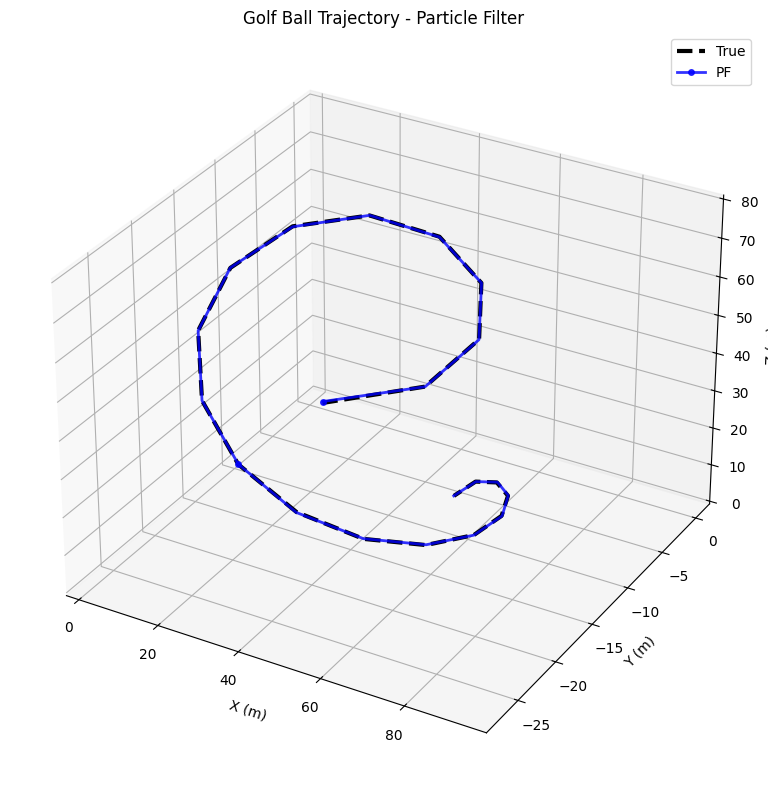

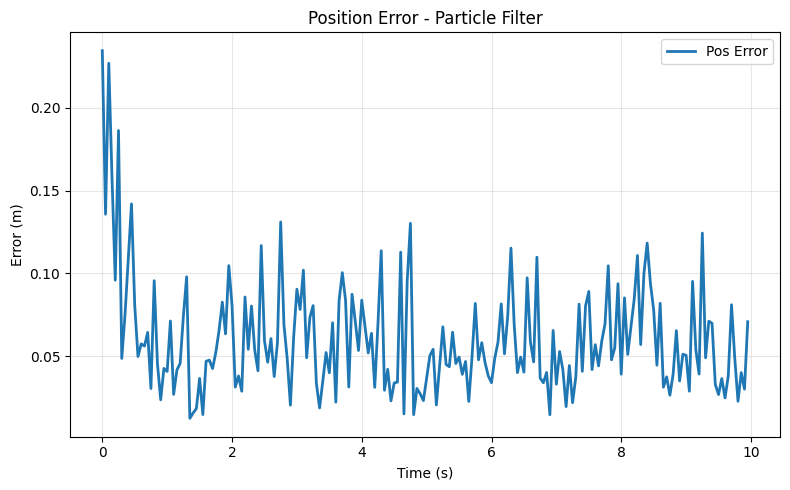

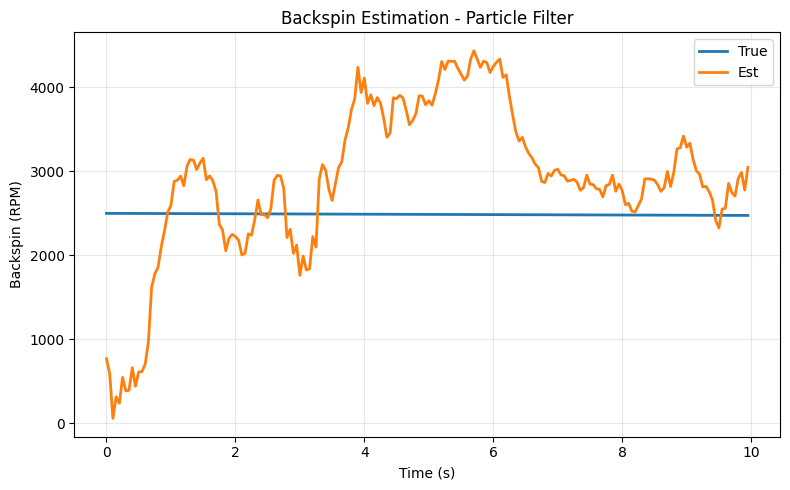

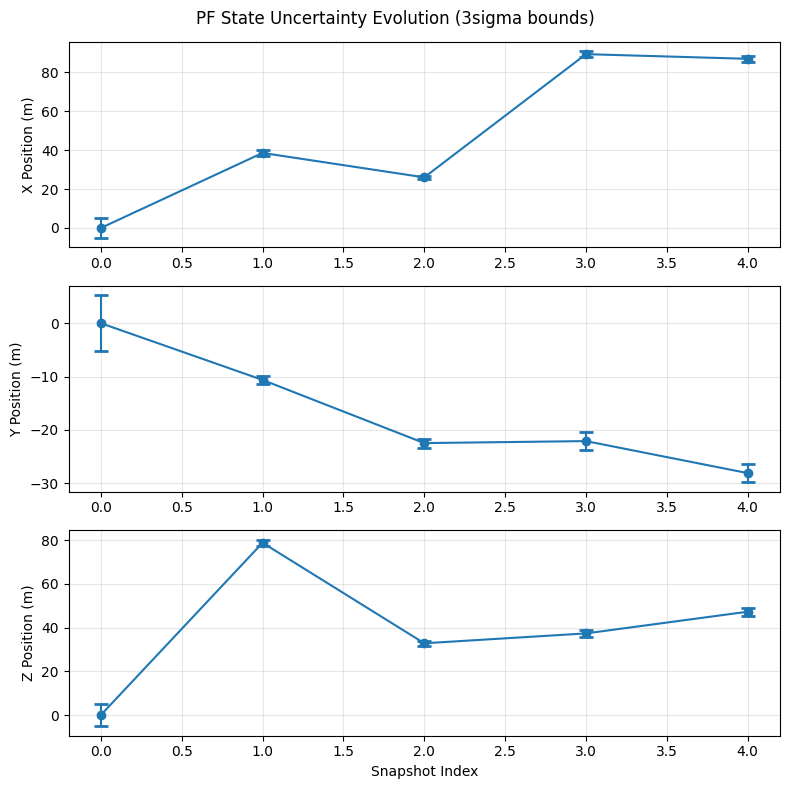

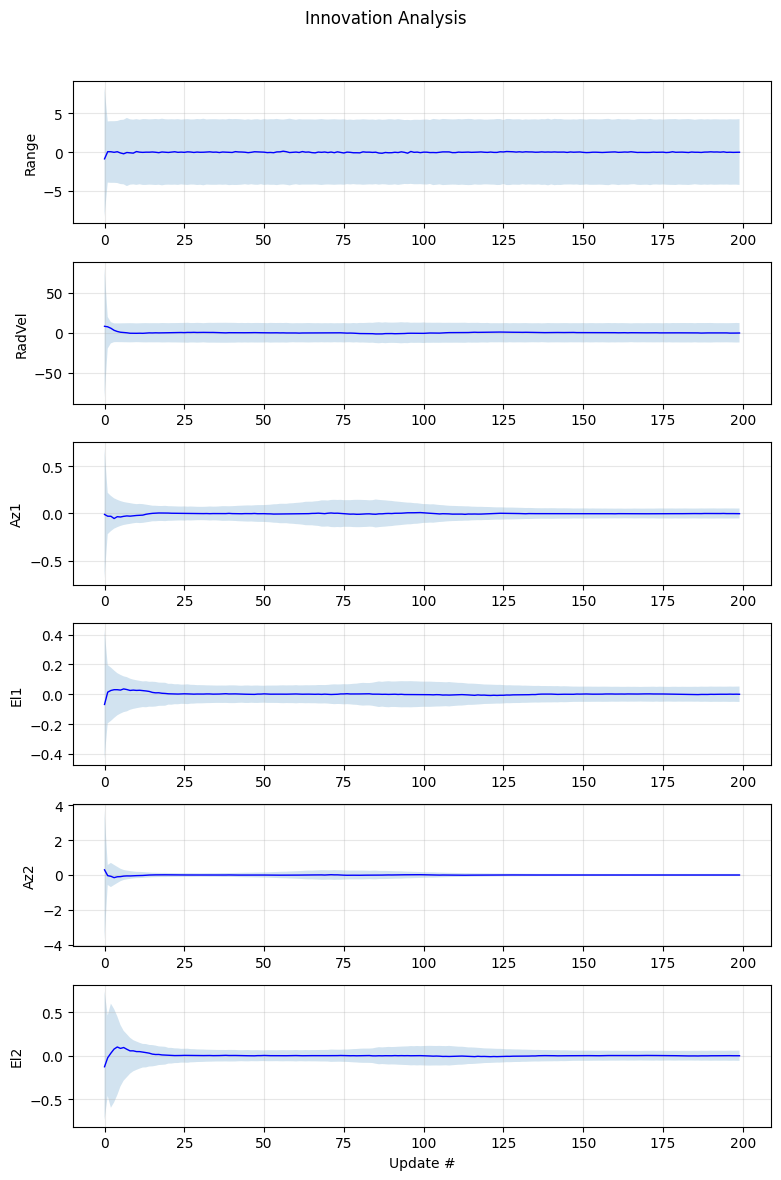

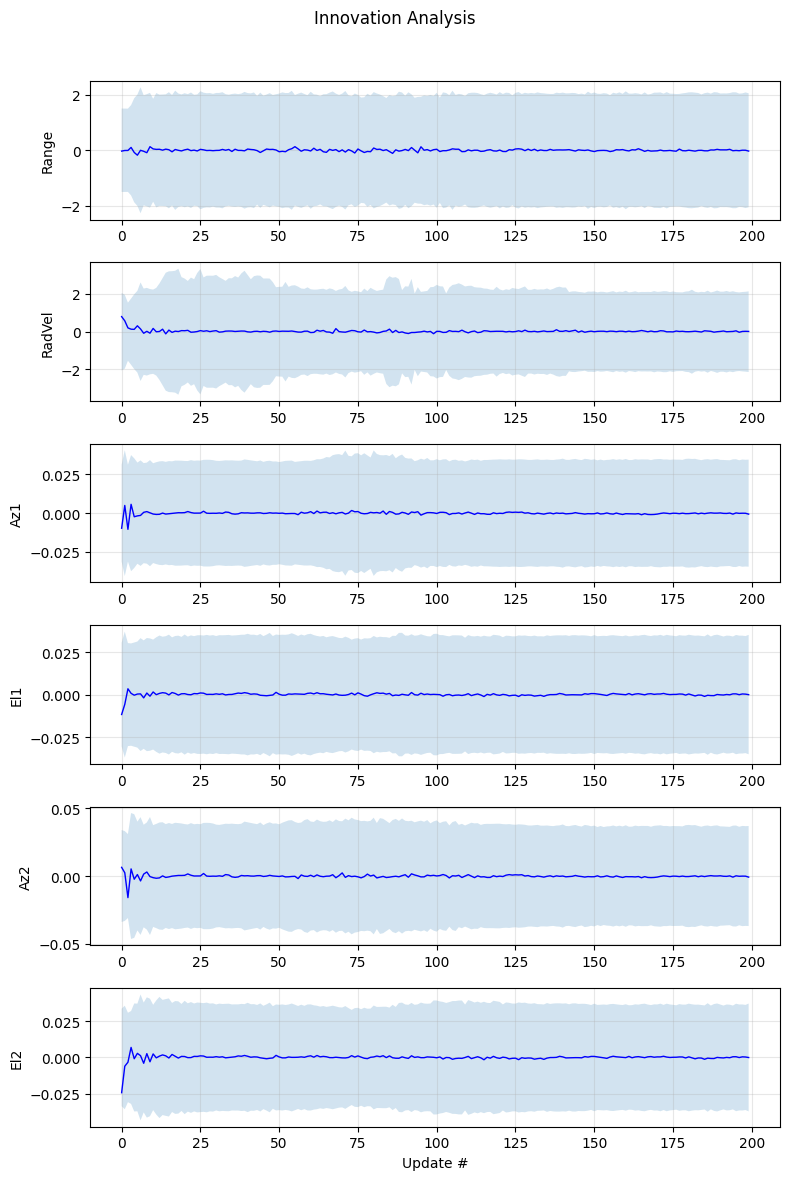

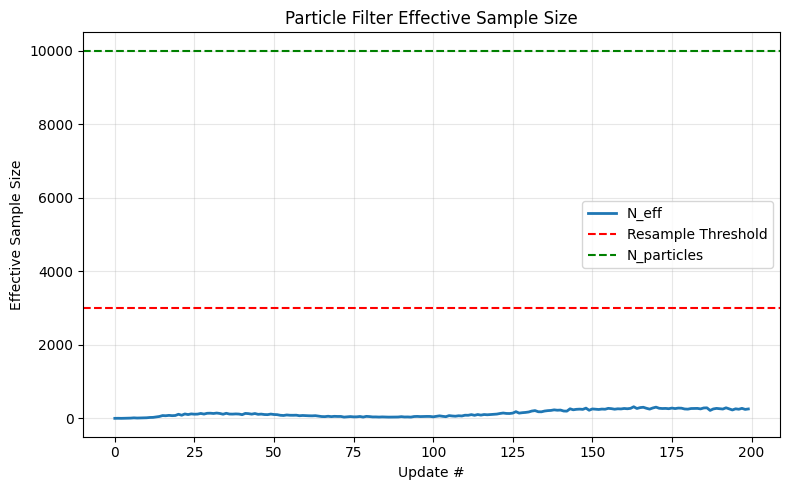

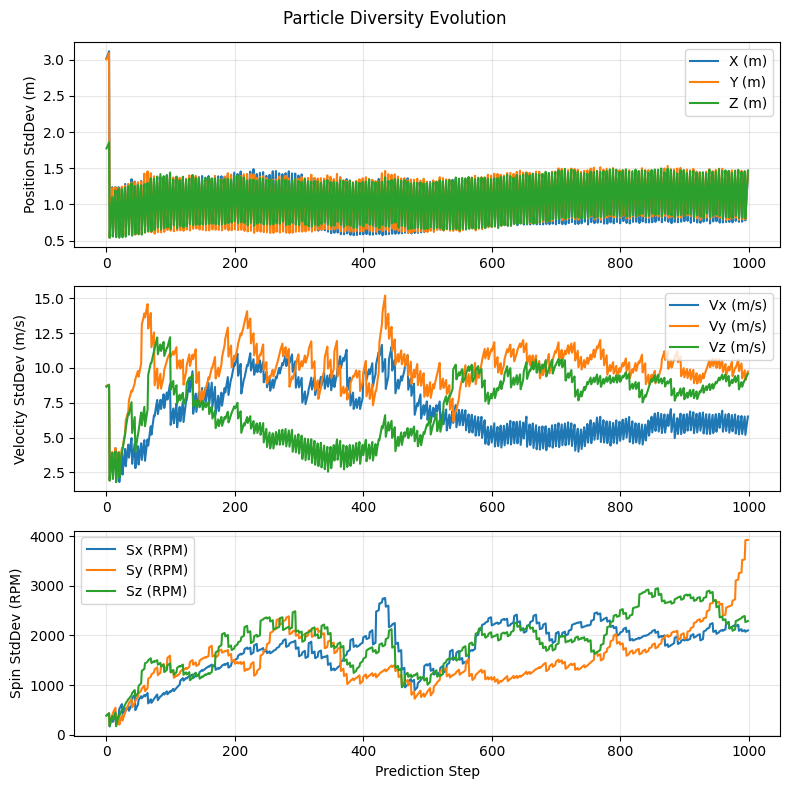

In [14]:
def main() -> None:
    """
    Main entry point for ball tracking demo.
    """
    np.random.seed(42)
    demo = BallTrackingDemo(
        physics=GolfBallPhysics(dt=0.01),
        sensors=GolfSensorSystem(),
        initial_speed=70,
        launch_angle=12,
        backspin_rpm=2500,
        sidespin_rpm=300,
        dt_meas=0.05,
    )
    demo.run()


if __name__ == "__main__":
    main()